In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch_geometric
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import cKDTree
import pickle
import gc
from tqdm import tqdm
import wandb
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import Linear
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torchmetrics.classification import BinaryAccuracy
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Data Preprocessing

parquet_file = 'Data/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'
parquet_file2 = 'Data/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet'
parquet_file3 = 'Data/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'

table = pq.read_table(parquet_file)
table2 = pq.read_table(parquet_file2)
table3 = pq.read_table(parquet_file3)

table = table.to_pandas()
table2 = table2.to_pandas()
table3 = table3.to_pandas()

table.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_1.pickle')
table2.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_2.pickle')
table3.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_3.pickle')

def convert_to_float(arr):
        if isinstance(arr, np.ndarray):
            return np.array([convert_to_float(x) for x in arr], dtype=float)
        else:
            return float(arr)
        
big_file = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_1.pickle')
big_file2 = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_2.pickle')
big_file3 = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_3.pickle')

big_file['X_jets'] = big_file['X_jets'].apply(convert_to_float)
big_file2['X_jets'] = big_file2['X_jets'].apply(convert_to_float)
big_file3['X_jets'] = big_file3['X_jets'].apply(convert_to_float)

big_file_combined = pd.concat([big_file, big_file2, big_file3], ignore_index=True)

mean = np.mean([np.mean(x, axis=(1,2)) for x in big_file_combined['X_jets']], axis=0)

std = np.std([np.std(x, axis=(1,2)) for x in big_file_combined['X_jets']], axis=0)

for i in range(len(big_file_combined['X_jets'])):
    for j in range(len(big_file_combined['X_jets'][i])):
                big_file_combined['X_jets'][i][j] = (big_file_combined['X_jets'][i][j] - mean[j]) / std[j]

big_file_combined = big_file_combined.sample(frac=1).reset_index(drop=True)

# big_file_combined.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_combined_normalised_reshaped.pickle')

train_df = big_file_combined.iloc[:int(0.8*len(big_file_combined))]
val_df = big_file_combined.iloc[int(0.8*len(big_file_combined)):]

train_df.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_combined_normalised_reshaped_train.pickle')
val_df.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_combined_normalised_reshaped_val.pickle')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


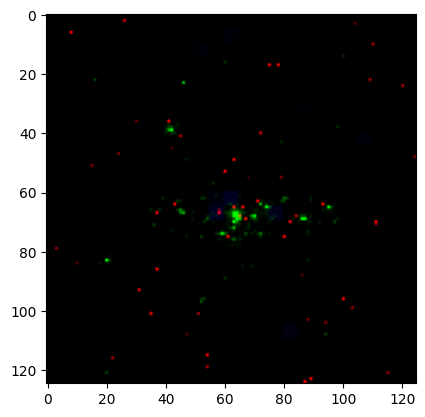

In [6]:
df = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_1.pickle')
img = df.iloc[0]
img_pix = img['X_jets']
def convert_to_float(arr):
    if isinstance(arr, np.ndarray):
        return np.array([convert_to_float(x) for x in arr], dtype=float)
    else:
        return float(arr)
img_pix = convert_to_float(img_pix)
img_pix_transposed = np.transpose(img_pix, (1, 2, 0))
# plot img_pix as an image
plt.imshow(img_pix_transposed, cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.37691059708595276 522.2991943359375


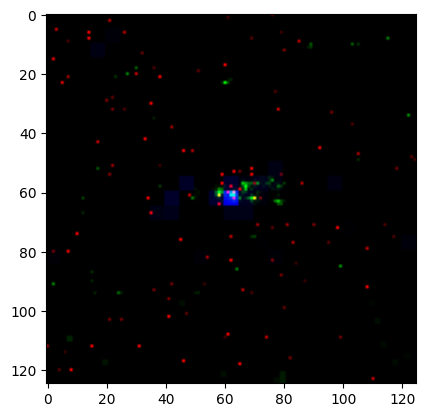

In [8]:
img_394 = df.iloc[394]['X_jets']
y_394 = df.iloc[394]['y']
img_394 = convert_to_float(img_394)
max_394 = np.max(img_394)
min_394 = np.min(img_394)
print(min_394, max_394)
img_394_transposed = np.transpose(img_394, (1, 2, 0))
# plot img_pix as an image
plt.imshow(img_394_transposed, cmap='gray')
plt.show()

In [10]:
def image_to_graph(image, image_label, num_nodes=100, distance_threshold=50):
    
    trans_image = np.transpose(image, (1, 2, 0))
    result = np.zeros_like(trans_image)
    for i in range(trans_image.shape[0]):
        for j in range(trans_image.shape[1]):
            result[i, j, np.argmax(trans_image[i, j])] = np.max(trans_image[i, j])
            
    result = np.transpose(result, (2, 0, 1))
    # Get the intensity threshold based on the 100th element
    flattened_image = result.reshape(-1)
    sorted_indices = np.argsort(flattened_image)[::-1]
    intensity_threshold = flattened_image[sorted_indices[num_nodes-1]]
    
    # Get the indices of cells where intensity exceeds the threshold
    node_indices = np.argwhere(result >= intensity_threshold)
    # Limit the number of nodes to num_nodes
    if len(node_indices) > num_nodes:
        node_indices = node_indices[:num_nodes]
    
    dist = torch.tensor(node_indices, dtype=torch.float)
    
    # Calculate pairwise distances between nodes
    distances = torch.cdist(dist[:, 1:], dist[:, 1:])  # Calculate distances based on (y, z) coordinates
    
    node_indices = node_indices[:, 1:]
    # Remove duplicates from node_indices
    node_indices = np.unique(node_indices, axis=0)
        
    # Create a torch tensor of argmax at node_indices of image
    x = torch.tensor(np.argmax(trans_image[node_indices[:, 0], node_indices[:, 1], :], axis=1), dtype=torch.float).unsqueeze(1)
    y = torch.tensor([image_label])
    
    
    # Remove self-edges by setting the diagonal to infinity
    num_nodes = len(node_indices)
    distances[range(num_nodes), range(num_nodes)] = float('inf')
    
    # Find pairs of nodes within the distance threshold
    pairs = torch.where(distances < distance_threshold)
    
    if len(pairs[0]) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 1), dtype=torch.float)
    else:
        edge_index = torch.stack(pairs, dim=0)
        edge_attr = distances[pairs].unsqueeze(1)
    
    # Create the Data object
    data = torch_geometric.data.Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    return data

In [11]:
def plot_image_and_graph(image, image_label, num_nodes=100, distance_threshold=50, node_size=10):
    image_transpose = np.transpose(image, (1, 2, 0))
    plt.imshow(image_transpose, cmap='gray')
    plt.show()
    
    data = image_to_graph(image, image_label, num_nodes=num_nodes, distance_threshold=distance_threshold)
    print("Number of nodes = ", data.x.shape[0])
    print("Number of edges = ", data.edge_index.shape[1])
    print("x is: ", data.x)
    print("sorted edge_attr is: ", data.edge_attr.sort(dim=0)[0])
    print("y is: ", data.y)
    print(data)
    g = torch_geometric.utils.to_networkx(data, to_undirected=True)
    nx.draw(g, node_size=node_size)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


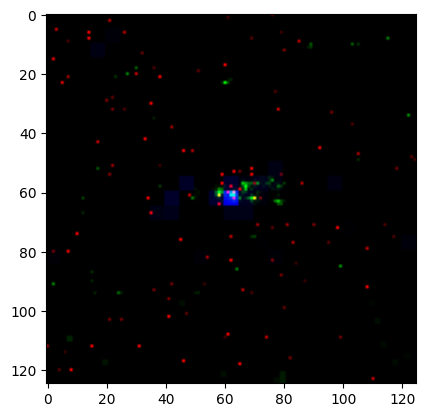

Number of nodes =  100
Number of edges =  6068
x is:  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [2.],
        [0.],
        [2.],
        [0.],
        [2.],
        [0.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [0.],
        [2.],
        [2.],
        [2.],
        [2.],
        

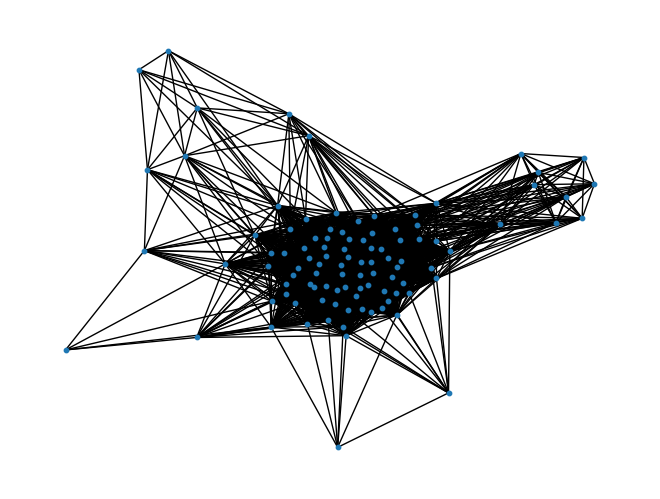

In [12]:
plot_image_and_graph(img_394, y_394, num_nodes=100, distance_threshold=50, node_size=10)

10


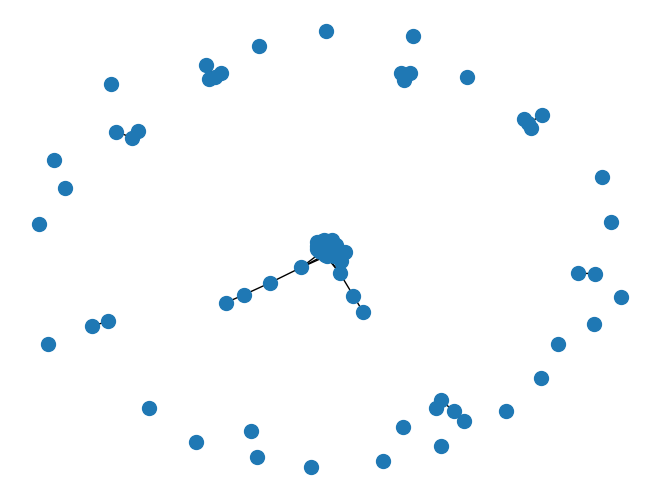

11


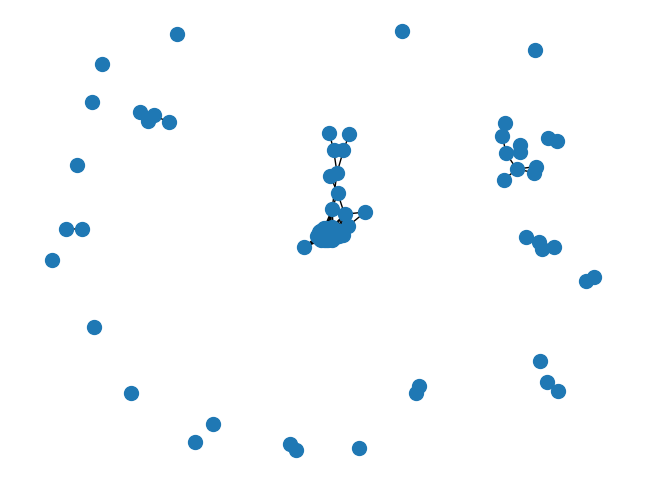

12


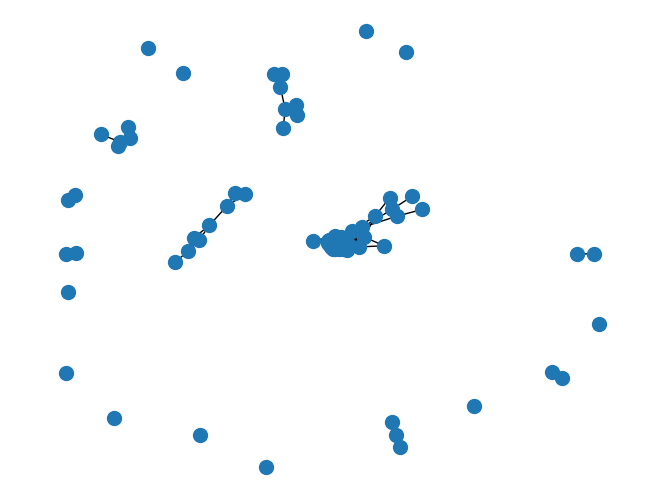

13


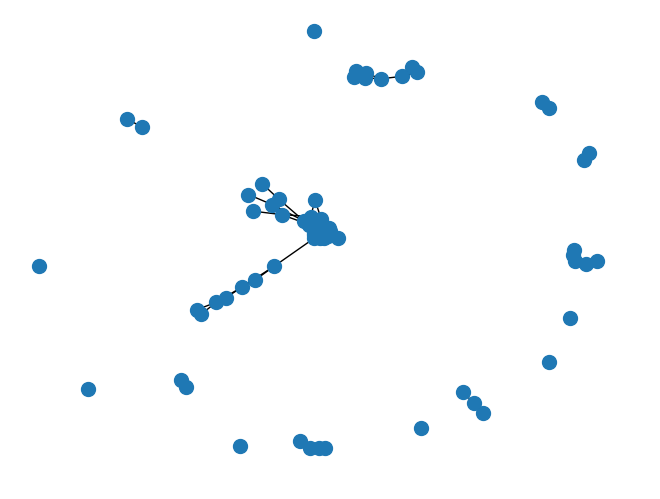

14


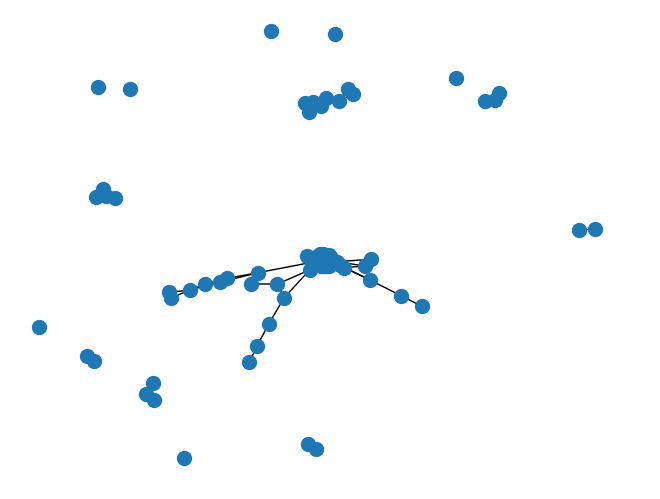

15


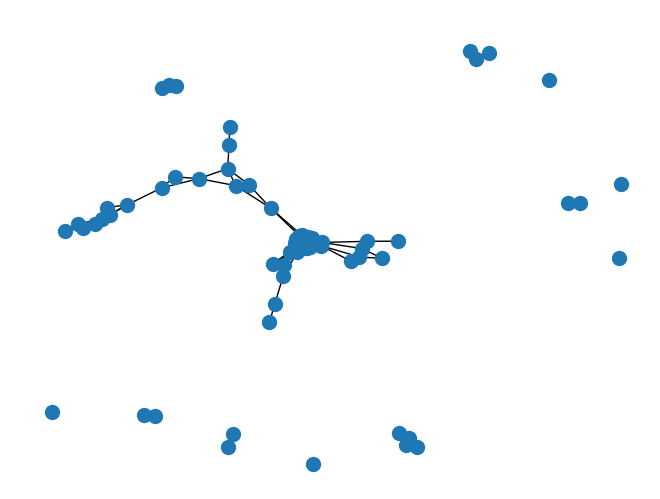

16


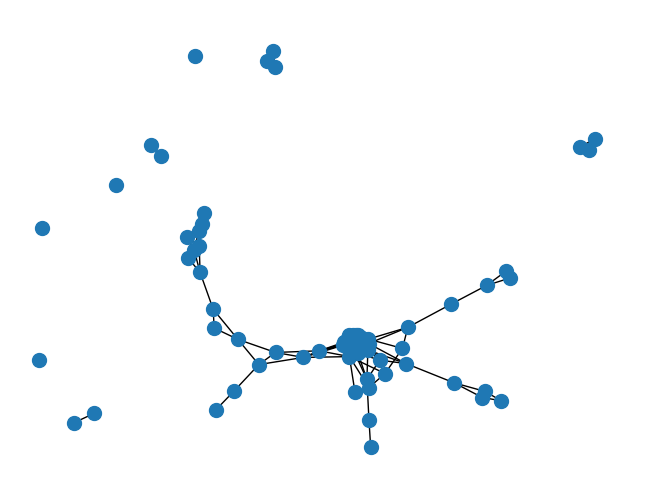

17


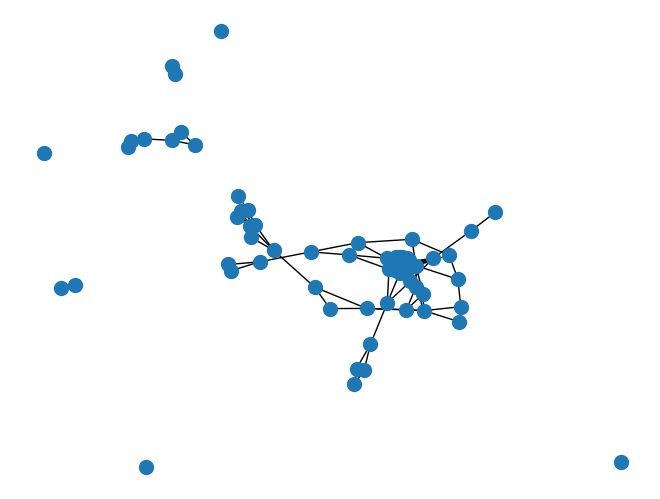

18


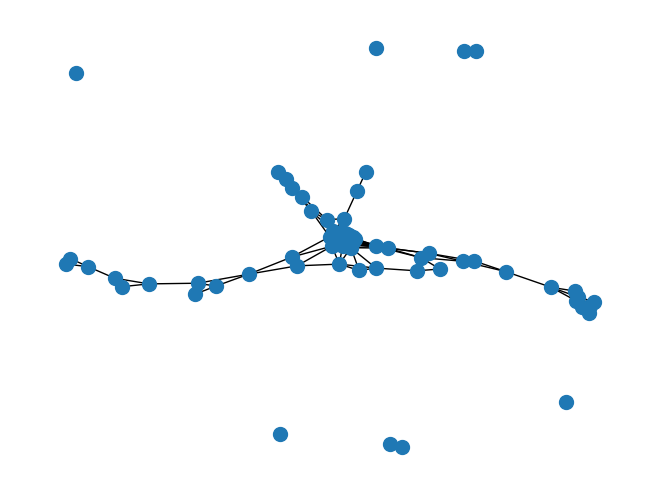

19


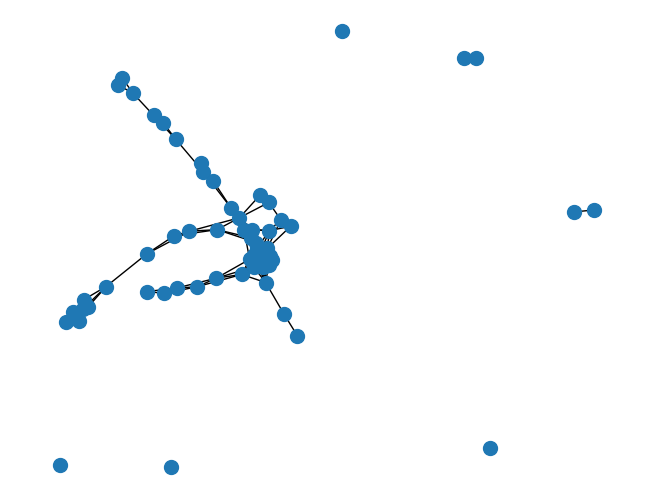

In [13]:
for i in range(10, 20):
    data_i = image_to_graph(img_394, y_394, num_nodes=100, distance_threshold=i)
    g_i = torch_geometric.utils.to_networkx(data_i, to_undirected=True)
    nx.draw(g_i, node_size=100)
    print(i)
    plt.show()
    # plot.show()

In [21]:
df_train = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_combined_normalised_reshaped_train.pickle')
df_train.shape

(111444, 4)

In [ ]:
processed_img_arr_train = []

for i in tqdm(range(len(df_train)), total = len(df_train)):
    img = df_train.iloc[i]['X_jets']
    label = df_train.iloc[i]['y']
    processed_img_arr_train.append(image_to_graph(img, label, num_nodes=100, distance_threshold=50))
    
with open('/scratch/mihika.sanghi/graph_train.pkl', 'wb') as f:
    pickle.dump(processed_img_arr_train, f)
    
del processed_img_arr_train, df_train

df_val = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_combined_normalised_reshaped_val.pickle')

processed_img_arr_val = []

for i in tqdm(range(len(df_val)), total = len(df_val)):
    img = df_val.iloc[i]['X_jets']
    label = df_val.iloc[i]['y']
    processed_img_arr_val.append(image_to_graph(img, label, num_nodes=100, distance_threshold=50))
    
with open('/scratch/mihika.sanghi/graph_val.pkl', 'wb') as f:
    pickle.dump(processed_img_arr_val, f)
    
del processed_img_arr_val, df_val

In [ ]:
class ParticleGraphDataset(Dataset):
    def __init__(self, data_path):
        super(ParticleGraphDataset, self).__init__()
        with open(data_path, 'rb') as f:
            data = pickle.load(f)
            
        self.graphs = data

    def len(self):
        return len(self.graphs)

    def get(self, index):
        data_point = self.graphs[index]

        return data_point
        # data_point has .x, .edge_index, .edge_attr, .y
        # x has dims (num_nodes, 1)
        # edge_index has dims (2, num_edges)
        # edge_attr has dims (num_edges, 1)
        # y has dims (1)

# Create datasets
train_dataset = ParticleGraphDataset('/scratch/mihika.sanghi/graph_train.pkl')
val_dataset = ParticleGraphDataset('/scratch/mihika.sanghi/graph_val.pkl')

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels).to(device)
        self.conv2 = GCNConv(hidden_channels, hidden_channels).to(device)
        self.conv3 = GCNConv(hidden_channels, hidden_channels).to(device)
        self.pool = global_mean_pool
        self.linear = nn.Linear(hidden_channels, num_classes).to(device)
        self.calculate_accuracy = BinaryAccuracy()

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First GCN layer
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second GCN layer
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Third GCN layer
        x = self.conv3(x, edge_index, edge_attr)

        # Apply global mean pooling to obtain graph-level representations
        x = self.pool(x, batch)

        # Pass the graph-level representations through the linear layer
        x = self.linear(x)

        return x

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=8)
model = GCN(1, 64, 2)
batch = next(iter(train_loader))
batch = batch.to(device)  # Move the batch to the same device as the model
outputs = model(batch)
outputs.shape, batch.y.shape, outputs.dtype, batch.y.dtype

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for i, batch in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        batch = batch.to(device)

        optimizer.zero_grad()

        outputs = model(batch)
        labels = batch.y.long()
        loss = criterion(outputs, labels)
        accuracy = model.calculate_accuracy(outputs.argmax(dim=1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy
    print(f"Epoch {epoch+1}, Training loss: {running_loss/len(train_loader)}, Accuracy: {running_accuracy/len(train_loader)}")
    
    if (epoch + 1) % 1 == 0:
        model.eval()
        running_loss = 0.0
        running_accuracy = 0.0
        with torch.no_grad():
            for i, batch in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
                batch = batch.to(device)
                outputs = model(batch)
                labels = batch.y.long()
                loss = criterion(outputs, labels)
                accuracy = model.calculate_accuracy(outputs.argmax(dim=1), labels)
                running_loss += loss.item()
                running_accuracy += accuracy
        print(f"Epoch {epoch+1}, Validation loss: {running_loss/len(val_loader)}, Accuracy: {running_accuracy/len(val_loader)}")

print('Finished Training')